**Challenge: Implement a Multiclass Classification Neural Network using PyTorch**

Objective:
Build a neural network using PyTorch to predict handwritten digits of MNIST.

Steps:

1. **Data Preparation**: Load the MNIST dataset using ```torchvision.datasets.MNIST```. Standardize/normalize the features. Split the dataset into training and testing sets using, for example, ```sklearn.model_selection.train_test_split()```. **Bonus scores**: *use PyTorch's built-* ```DataLoader``` *to split the dataset*.

2. **Neural Network Architecture**: Define a simple feedforward neural network using PyTorch's ```nn.Module```. Design the input layer to match the number of features in the MNIST dataset and the output layer to have as many neurons as there are classes (10). You can experiment with the number of hidden layers and neurons to optimize the performance. **Bonus scores**: *Make your architecture flexibile to have as many hidden layers as the user wants, and use hyperparameter optimization to select the best number of hidden layeres.*

3. **Loss Function and Optimizer**: Choose an appropriate loss function for multiclass classification. Select an optimizer, like SGD (Stochastic Gradient Descent) or Adam.

4. **Training**: Write a training loop to iterate over the dataset.
Forward pass the input through the network, calculate the loss, and perform backpropagation. Update the weights of the network using the chosen optimizer.

5. **Testing**: Evaluate the trained model on the test set. Calculate the accuracy of the model.

6. **Optimization**: Experiment with hyperparameters (learning rate, number of epochs, etc.) to optimize the model's performance. Consider adjusting the neural network architecture for better results. **Notice that you can't use the optimization algorithms from scikit-learn that we saw in lab1: e.g.,** ```GridSearchCV```.


In [7]:

import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = 0.7
test_size = 1 - train_size

train_dataset, test_dataset = train_test_split(mnist_dataset, test_size=test_size, random_state=42)

batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init


class MNISTmodel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers,dropout_rate=0.5):
        super(MNISTmodel, self).__init__()
        #initial input layer
        self.input_layer = nn.Linear(input_size, hidden_size)

        #initialize the weight
        init.xavier_uniform_(self.input_layer.weight)

        #variable number of hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU()
            ) for _ in range(num_hidden_layers)
        ])

        #output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        #output layer weight update
        init.xavier_uniform_(self.output_layer.weight)

        
        self.relu = nn.ReLU()
        self.dropout= nn.Dropout(p=dropout_rate)
        



    def forward(self, x):
        x = x.view(-1, self.input_layer.in_features)

        x = self.dropout(self.relu(self.input_layer(x)))

        for layer in self.hidden_layers:
            x = self.relu(layer(x))
      
        x = self.output_layer(x)
        return x

torch.manual_seed(42)

In [ ]:
import numpy as np

import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=MNISTmodel(input_size=28*28,hidden_size=256,output_size=10,num_hidden_layers=5,dropout_rate=0.3).to(device)
loss = nn.CrossEntropyLoss()
lr=0.0001
optimizer = optim.AdamW(model.parameters(),lr=lr)

train_loss=[]
test_acc=[]
epochs= 40
for epoch in range(epochs):
  losses = []
  model.train()
  for inputs, labels in train_loader:
    inputs,labels = inputs.to(device),labels.to(device)
   
    y_pred = model(inputs)
    batch_loss = loss(y_pred, labels)
    losses.append(batch_loss.item())
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
  train_loss.append(np.mean(losses))
  print(f'Epoch {epoch + 1} --> loss = {np.mean(losses)}')

  acc = 0
  count = 0
  model.eval()
  for inputs, labels in test_loader:
    inputs,labels = inputs.to(device),labels.to(device) 
    y_pred = model(inputs)
    acc += (torch.argmax(y_pred, 1) == labels).float().sum()
    count += len(labels)
  acc /= count
  test_acc.append((acc*100).item())
  print("Epoch %d: model accuracy %.2f%%" % (epoch+1, acc*100))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.arange(1,epochs+1),  train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.suptitle(f'Hyperparameters: LR={lr},Optimizer={type(optimizer).__name__},Loss={type(loss).__name__}', y=1.02)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(test_acc)) + 1,  test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')

plt.tight_layout()
plt.show()

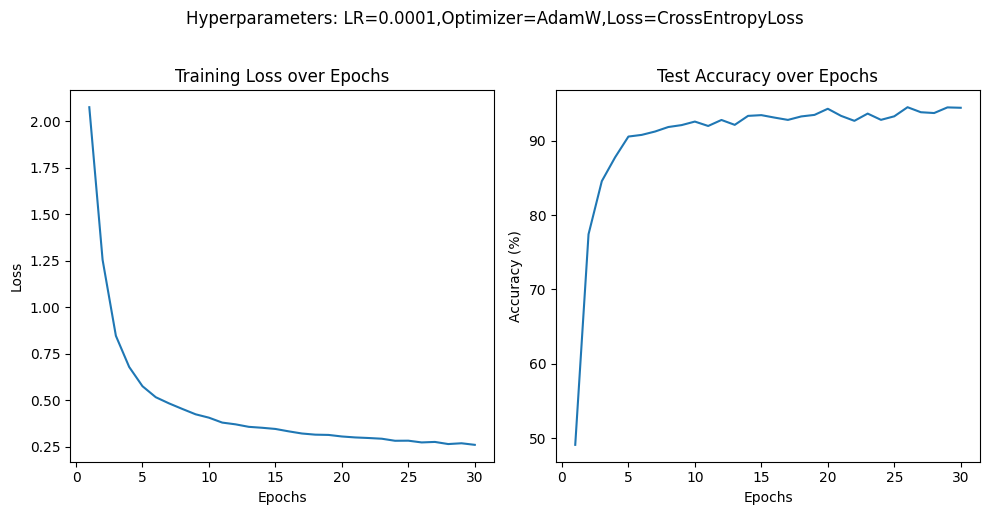

Initial hyperparameters setting: hidden_layers_size=64, hidden_layers_number=12,dropout=0.3, accuracy= 94,5%

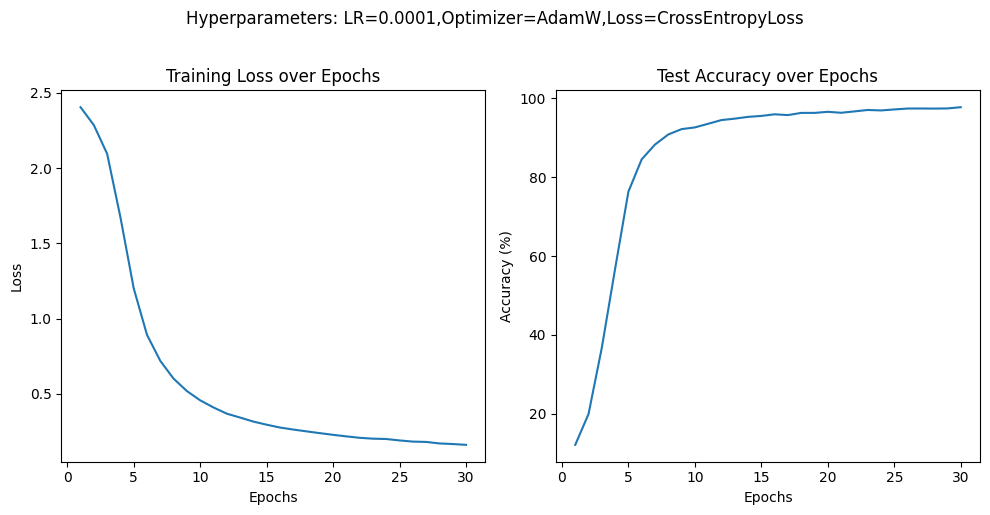

hidden_layers_size=128, hidden_layers_number=20,dropout=0.3, accuracy=97,7%

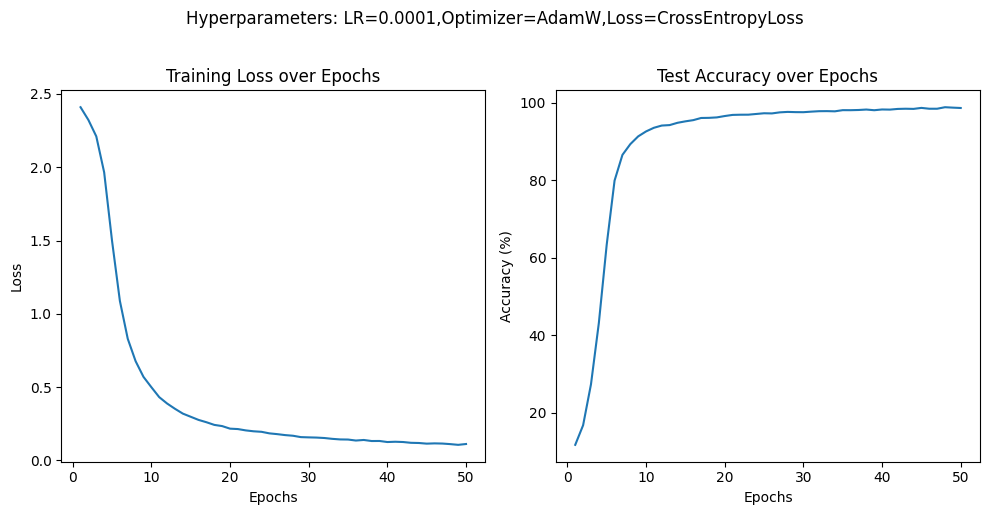

hidden_layer_size=128, hidden_layers_number=20,dropout=0.3, accuracy=98,5%. Increasing the number of epochs allows the model to reach a little bit higher accuracy score, the best compromise should be around 40 epochs.

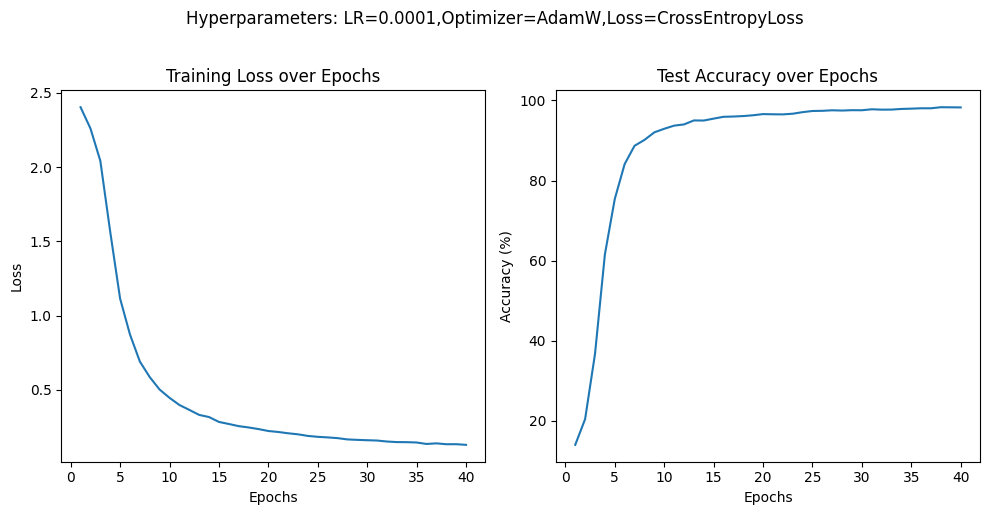

hidden_layers=128, hidden_layers_number=20,dropout=0.3, accuracy=98,35%.

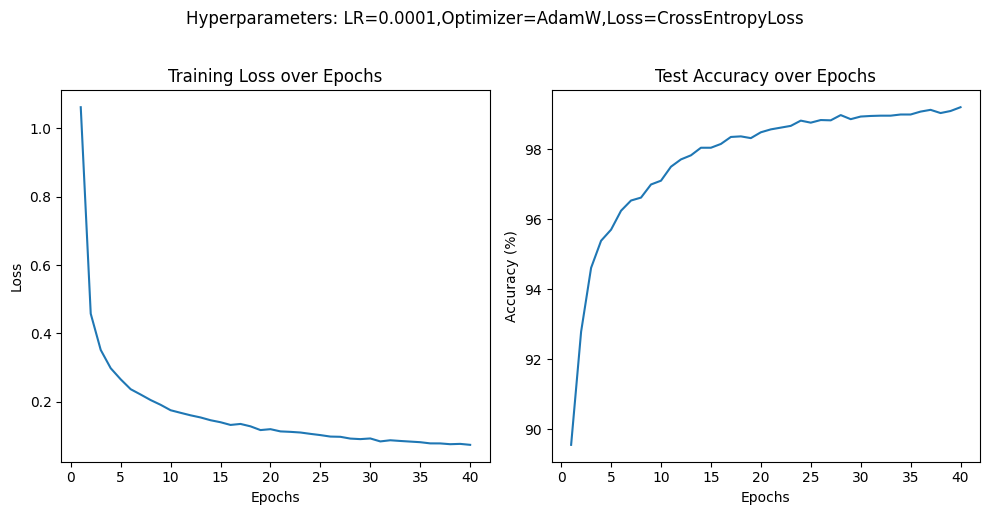

hidden_layers_size=128, hidden_layers_number=10, dropout=0.3, accuracy=99,20%. That shows that having a number of hidden layers too high brings the model to overfit.

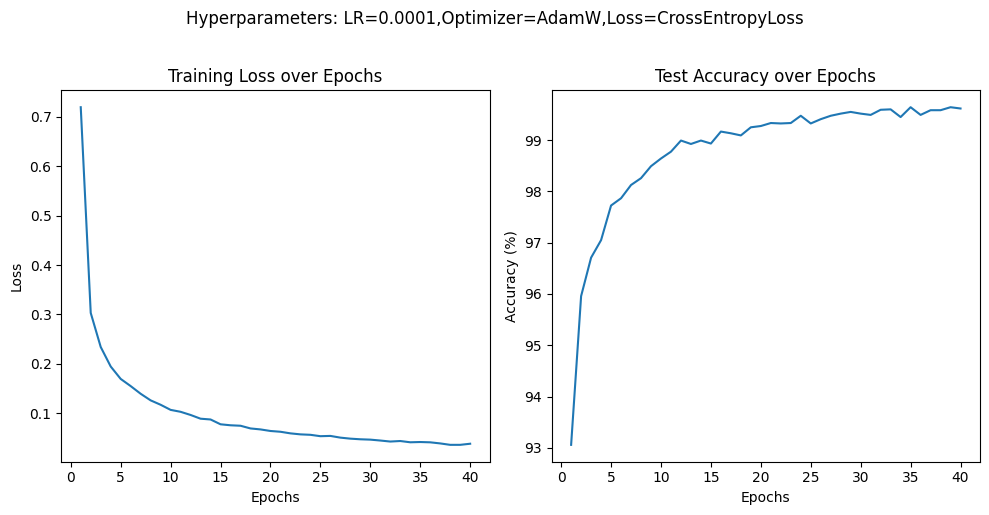

hidden_layers_size=256, hidden_layers_number=5, dropout=0.3, accuracy=99,70%. Increasing the size of the hidden layers allows the model to reach higher accuracy score, but also higher computational cost.